In [1]:
## FASE 1: SETUP DAN PEMUATAN DATA

# Import library dasar
import pandas as pd
import numpy as np
import re
import time

# Import untuk Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from ast import literal_eval # Untuk mengubah string '[...]' menjadi list

# Import untuk LDA & Koherensi
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel

# Import untuk Klasifikasi & Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Import untuk Visualisasi
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import umap

print("Semua library berhasil diimpor.")

# --- Memuat Dataset ---
# Ganti 'nama_file_anda.csv' dengan nama file CSV Anda yang sebenarnya.
try:
    df = pd.read_csv('hasil_scraping_berita_bangsaonlinecopy.csv')
    print(f"\nDataset berhasil dimuat. Jumlah data: {len(df)} baris.")
    print("Contoh data awal:")
    print(df.head())
except FileNotFoundError:
    print("\nError: File tidak ditemukan. Pastikan nama file CSV sudah benar.")
    # Jika file tidak ditemukan, hentikan proses.
    # df = pd.DataFrame()

Semua library berhasil diimpor.

Dataset berhasil dimuat. Jumlah data: 3653 baris.
Contoh data awal:
   id_berita kategori                                              judul  \
0     153410    Jatim  Diduga Kasus Korupsi, Kejari Geledah Kantor Pe...   
1     153408    Jatim  Pria asal Surabaya Meninggal Mendadak di Pasar...   
2     153407    Jatim  Polres Tuban Kembalikan BB Motor hingga Handph...   
3     153406    Jatim  TMMD ke-126 Sidoarjo Bangun Rumah Warga Guna W...   
4     153405    Jatim  Dana Transfer Dipangkas Pusat, Bupati Gresik S...   

                                          isi_berita  \
0  SURABAYA, BANGSAONLINE.com- Kejari Tanjung Per...   
1  KOTA PASURUAN,BANGSAONLINE.com- Suasana Pasar ...   
2  TUBAN, BANGSAONLINE.com- Satreskrim Polres Tub...   
3  SIDOARJO,BANGSAONLINE.com- Program TNI Manungg...   
4  GRESIK,BANGSAONLINE.com- Bupati Gresik, Fandi ...   

                                                link  
0  https://bangsaonline.com/berita/153410/diduga-.

In [2]:
## FASE 2: PRA-PEMROSESAN TEKS DAN PENGGABUNGAN KATEGORI

# --- A. Penggabungan Kategori (Opsional, tapi Sangat Direkomendasikan) ---
# Berdasarkan analisis kita, banyak kategori regional yang tumpang tindih.
# Menggabungkannya akan sangat membantu model.
print("\n--- Memulai Penggabungan Kategori ---")
mapping_kategori = {
    'Jatim': 'Berita Regional Jatim', 'Jatim Barat': 'Berita Regional Jatim',
    'Jatim Madura': 'Berita Regional Jatim', 'Jatim Metro': 'Berita Regional Jatim',
    'Jatim Selatan': 'Berita Regional Jatim', 'Jatim Tengah': 'Berita Regional Jatim',
    'Jatim Timur': 'Berita Regional Jatim', 'Jatim Utara': 'Berita Regional Jatim'
}
df['kategori'] = df['kategori'].replace(mapping_kategori)
print(f"Jumlah kategori setelah digabungkan: {df['kategori'].nunique()}")


# --- B. Pra-pemrosesan Teks ---
print("\n--- Memulai Pra-pemrosesan Teks ---")

# Inisialisasi stemmer Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Dapatkan daftar stopwords Bahasa Indonesia dari NLTK
list_stopwords = stopwords.words('indonesian')

def preprocess_text(text):
    # 1. Case Folding: mengubah teks menjadi huruf kecil
    text = text.lower()
    # 2. Hapus Noise: menghapus URL, angka, dan karakter non-alfabet
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[-+]?[0-9]+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 3. Tokenisasi: memecah teks menjadi kata
    tokens = word_tokenize(text)
    # 4. Stopwords Removal & Stemming
    cleaned_tokens = []
    for token in tokens:
        if token not in list_stopwords:
            stemmed_token = stemmer.stem(token)
            cleaned_tokens.append(stemmed_token)
    return cleaned_tokens

# Terapkan fungsi preprocessing. Ini mungkin memakan waktu beberapa menit.
# Ganti 'isi_berita' dengan nama kolom berita Anda.
df['tokens'] = df['isi_berita'].apply(preprocess_text)

print("Pra-pemrosesan Teks selesai.")
print("Contoh hasil preprocessing:")
print(df[['kategori', 'tokens']].head())


--- Memulai Penggabungan Kategori ---
Jumlah kategori setelah digabungkan: 30

--- Memulai Pra-pemrosesan Teks ---
Pra-pemrosesan Teks selesai.
Contoh hasil preprocessing:
                kategori                                             tokens
0  Berita Regional Jatim  [surabaya, bangsaonlinecom, kejar, tanjung, pe...
1  Berita Regional Jatim  [kota, pasuruanbangsaonlinecom, suasana, pasar...
2  Berita Regional Jatim  [tuban, bangsaonlinecom, satreskrim, polres, t...
3  Berita Regional Jatim  [sidoarjobangsaonlinecom, program, tni, manung...
4  Berita Regional Jatim  [gresikbangsaonlinecom, bupati, gresik, fandi,...



Kamus dibuat dan difilter. Jumlah kata unik: 3833

--- Menjalankan HDP untuk estimasi jumlah topik... ---
✅ HDP mengestimasi ada sekitar: 20 topik.

--- Menjalankan pencarian koherensi dari 5 hingga 40 topik... ---
Selesai menghitung untuk 5 topik...
Selesai menghitung untuk 10 topik...
Selesai menghitung untuk 15 topik...
Selesai menghitung untuk 20 topik...
Selesai menghitung untuk 25 topik...
Selesai menghitung untuk 30 topik...
Selesai menghitung untuk 35 topik...

Total waktu pencarian koherensi: 4.59 menit


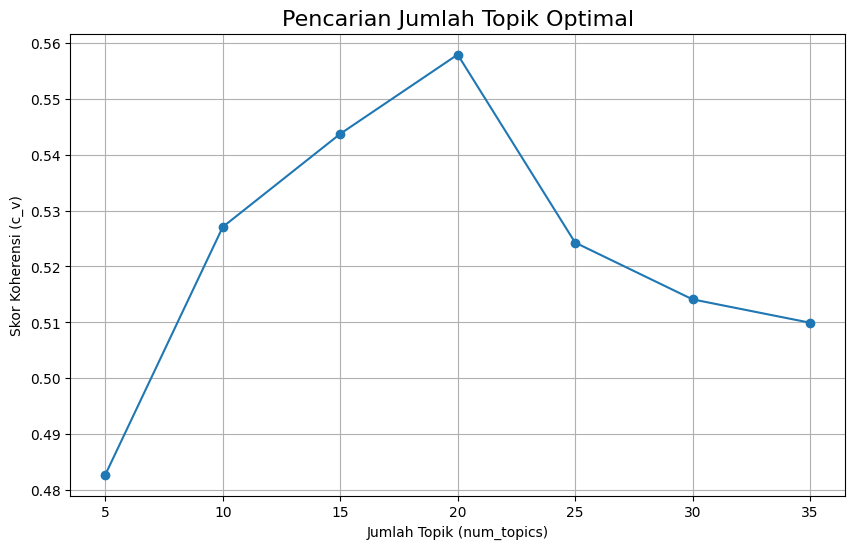


✅ Jumlah topik optimal yang ditemukan: 20

--- Melatih model LDA final dengan topik optimal... ---
Ekstraksi fitur LDA selesai.
Bentuk matriks fitur (X): (3653, 20)


In [3]:
## FASE 3: EKSTRAKSI FITUR LDA & PENCARIAN TOPIK OPTIMAL

# Siapkan data untuk Gensim
documents = df['tokens'].tolist()
dictionary = Dictionary(documents)

# --- A. Filter Kamus (Sesuai Referensi & Praktik Terbaik) ---
# Membuang kata yang terlalu jarang atau terlalu sering muncul.
# Ini meningkatkan kualitas topik secara signifikan.
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in documents]
print(f"\nKamus dibuat dan difilter. Jumlah kata unik: {len(dictionary)}")


# --- B. Estimasi Jumlah Topik dengan HDP (Langkah Cerdas) ---
print("\n--- Menjalankan HDP untuk estimasi jumlah topik... ---")
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
estimated_num_topics = len(hdp_model.print_topics())
print(f"✅ HDP mengestimasi ada sekitar: {estimated_num_topics} topik.")


# --- C. Mencari Jumlah Topik Terbaik dengan Plot Koherensi ---
def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    start_time = time.time()
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             random_state=42, passes=10, workers=3)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Selesai menghitung untuk {num_topics} topik...")
    total_time = time.time() - start_time
    print(f"\nTotal waktu pencarian koherensi: {total_time/60:.2f} menit")
    return coherence_values

# Atur rentang pencarian di sekitar hasil HDP
search_start = max(2, estimated_num_topics - 15)
search_limit = estimated_num_topics + 20
search_step = 5

print(f"\n--- Menjalankan pencarian koherensi dari {search_start} hingga {search_limit} topik... ---")
coherence_values = compute_coherence_values_multicore(dictionary=dictionary, corpus=corpus, texts=documents,
                                                    start=search_start, limit=search_limit, step=search_step)

# Tampilkan grafik
x = range(search_start, search_limit, search_step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.title("Pencarian Jumlah Topik Optimal", fontsize=16)
plt.xlabel("Jumlah Topik (num_topics)")
plt.ylabel("Skor Koherensi (c_v)")
plt.xticks(x)
plt.grid(True)
plt.show()

# Pilih jumlah topik terbaik (yang memiliki skor koherensi tertinggi)
optimal_num_topics = x[np.argmax(coherence_values)]
print(f"\n✅ Jumlah topik optimal yang ditemukan: {optimal_num_topics}")


# --- D. Latih Model LDA Final & Ekstrak Fitur ---
print("\n--- Melatih model LDA final dengan topik optimal... ---")
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics,
                         random_state=42, passes=15)

# Ekstrak fitur (distribusi topik) untuk setiap dokumen
def get_lda_features(lda_model, bow_corpus):
    features = []
    for doc_bow in bow_corpus:
        topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        doc_features = [0.0] * optimal_num_topics
        for topic_id, prob in topic_distribution:
            doc_features[topic_id] = prob
        features.append(doc_features)
    return np.array(features)

X = get_lda_features(lda_model, corpus)
y = df['kategori'].values

print("Ekstraksi fitur LDA selesai.")
print(f"Bentuk matriks fitur (X): {X.shape}")

In [4]:
## FASE 4: PELATIHAN DAN EVALUASI MODEL KLASIFIKASI

# --- A. Bagi Data menjadi Latih dan Uji ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData dibagi. Jumlah data latih: {len(X_train)}, Jumlah data uji: {len(X_test)}")


# --- B. Latih Model Klasifikasi (SVM) ---
# Kita gunakan SVM sesuai hasil eksperimen dan referensi.
classifier = SVC(kernel='linear', random_state=42, probability=True)

print("\n--- Memulai pelatihan model SVM... ---")
classifier.fit(X_train, y_train)
print("Pelatihan selesai.")


# --- C. Evaluasi Kinerja Model ---
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- HASIL EVALUASI AKHIR ---")
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("\nLaporan Klasifikasi (Classification Report):")
print(classification_report(y_test, y_pred))


Data dibagi. Jumlah data latih: 2922, Jumlah data uji: 731

--- Memulai pelatihan model SVM... ---
Pelatihan selesai.

--- HASIL EVALUASI AKHIR ---
Akurasi Model: 47.33%

Laporan Klasifikasi (Classification Report):
                          precision    recall  f1-score   support

   Berita Regional Jatim       0.41      0.93      0.57       160
               Birokrasi       0.00      0.00      0.00        20
                   Dunia       0.50      0.05      0.09        20
                 Ekonomi       0.95      0.95      0.95        20
            Entrepreneur       0.43      0.15      0.22        20
                   Figur       0.25      0.05      0.08        20
        Hukum - Kriminal       0.00      0.00      0.00        20
               Kesehatan       1.00      0.15      0.26        20
Komunitas dan Lingkungan       0.00      0.00      0.00        20
                 Kuliner       0.60      0.75      0.67        20
               Lifestyle       0.73      0.55      0.63 

c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---


c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Rizky\AppData\Local\Temp\ipykernel_30680\4126789932.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Spectral", len(labels))
c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:1112: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


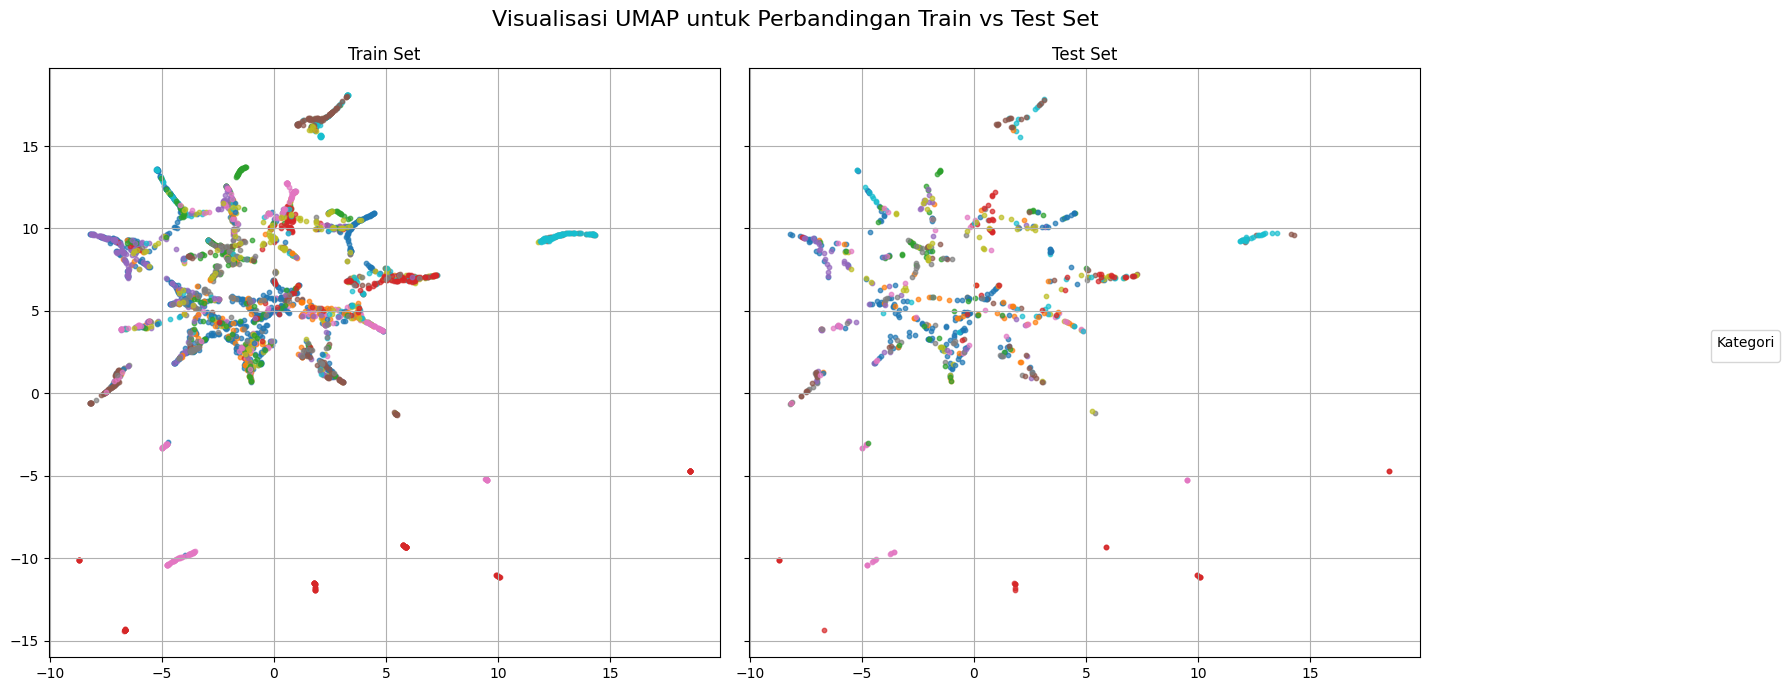


--- Selesai ---


In [5]:
## FASE 5: ANALISIS LANJUTAN DAN VISUALISASI (UMAP)

print("\n--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---")

# --- A. Siapkan Data untuk Visualisasi ---
labels = list(pd.Series(y_train).unique())
label_map = {label: i for i, label in enumerate(labels)}
y_train_numeric = pd.Series(y_train).map(label_map).values
y_test_numeric = pd.Series(y_test).map(label_map).values

# Gabungkan, skalakan, dan terapkan UMAP
X_combined = np.concatenate((X_train, X_test), axis=0)
X_scaled = StandardScaler().fit_transform(X_combined)
reducer = umap.UMAP(n_components=2, random_state=42)
X_2d_combined = reducer.fit_transform(X_scaled)
x2d_train = X_2d_combined[:len(X_train)]
x2d_test = X_2d_combined[len(X_train):]

# --- B. Fungsi untuk Menggambar Plot ---
def plot_topic_clusters(ax, x2d, y_numeric, labels, title):
    ax.set_title(title)
    colors = cm.get_cmap("Spectral", len(labels))
    for i, label_name in enumerate(labels):
        ax.scatter(x2d[y_numeric == i, 0], x2d[y_numeric == i, 1],
                   label=label_name, alpha=0.7, s=10)
    ax.grid(True)
    return ax

# --- C. Buat dan Tampilkan Dua Subplot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
plot_topic_clusters(axes[0], x2d_train, y_train_numeric, labels, "Train Set")
plot_topic_clusters(axes[1], x2d_test, y_test_numeric, labels, "Test Set")
fig.suptitle("Visualisasi UMAP untuk Perbandingan Train vs Test Set", fontsize=16)

# Tambahkan legenda di luar plot
handles, current_labels = axes[0].get_legend_handles_labels()
# Gunakan `num` untuk memastikan semua handle dibuat jika kategori banyak
handles, _ = axes[0].collections[0].legend_elements(num=len(labels))
fig.legend(handles, labels, title="Kategori", loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print("\n--- Selesai ---")